In [ ]:
from google.colab import files
uploaded = files.upload()

for i in uploaded.keys():
  print('user uploaded file {name} with the length {length} bytes'.format(name = i, length = len(uploaded[i])))

#tehn move kaggle.json into the folder where api expects to find it
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
user uploaded file kaggle.json with the length 68 bytes


In [ ]:
!kaggle datasets download -d galinakg/interior-design-images-and-metadata

Dataset URL: https://www.kaggle.com/datasets/galinakg/interior-design-images-and-metadata
License(s): MIT
  0% 0.00/65.0M [00:00<?, ?B/s]
100% 65.0M/65.0M [00:00<00:00, 1.36GB/s]


In [ ]:
from zipfile import ZipFile
file_name = "/content/interior-design-images-and-metadata.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [ ]:
!pip install colorthief

In [ ]:
import os
import pandas as pd
from colorthief import ColorThief
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib
import ast


In [ ]:
def extract_dominant_and_palette(image_path):
    try:
        color_thief = ColorThief(image_path)
        dominant_color = color_thief.get_color(quality=1)
        palette = color_thief.get_palette(color_count=5)
        return dominant_color, palette
    except Exception as e:
        pprint("Error processing:", image_path, "|", e)
        return None, None


In [ ]:
def extract_features_from_folder(folder_path):
    data = []
    for room_type in os.listdir(folder_path):
        room_path = os.path.join(folder_path, room_type)
        if os.path.isdir(room_path):
            for style in os.listdir(room_path):
                style_path = os.path.join(room_path, style)
                if os.path.isdir(style_path):
                    for filename in tqdm(os.listdir(style_path)):
                        if filename.endswith(('.jpg', '.png', '.jpeg')):
                            image_path = os.path.join(style_path, filename)
                            dominant_color, palette = extract_dominant_and_palette(image_path)
                            if dominant_color:
                                data.append({
                                    "image_path": image_path,
                                    "room_type": room_type,
                                    "style": style,
                                    "dominant_color": dominant_color,
                                    "palette": palette
                                })
    return pd.DataFrame(data)


In [ ]:
# Load and save features
features_df = extract_features_from_folder("/content/Pinterest Interior Design Images and Metadata")
features_df.to_csv("features.csv", index=False)


100%|██████████| 184/184 [00:55<00:00,  3.30it/s]


In [ ]:
style_color_mapping = features_df.groupby("style")["dominant_color"].apply(list).to_dict()

In [ ]:
features_df

,image_path,room_type,style,dominant_color,palette
0,/content/Pinterest Interior Design Images and ...,kitchen,modern,"(196, 170, 141)","[(196, 170, 141), (56, 42, 29), (208, 213, 218..."
1,/content/Pinterest Interior Design Images and ...,kitchen,modern,"(211, 200, 191)","[(211, 199, 191), (107, 79, 58), (142, 107, 77..."
2,/content/Pinterest Interior Design Images and ...,kitchen,modern,"(140, 128, 113)","[(140, 130, 115), (46, 41, 34), (210, 206, 193..."
3,/content/Pinterest Interior Design Images and ...,kitchen,modern,"(146, 130, 116)","[(176, 158, 138), (39, 45, 58), (94, 96, 104),..."
4,/content/Pinterest Interior Design Images and ...,kitchen,modern,"(48, 48, 45)","[(48, 47, 45), (202, 202, 196), (136, 131, 121..."
...,...,...,...,...,...
4134,/content/Pinterest Interior Design Images and ...,living_room,boho,"(183, 170, 147)","[(182, 169, 147), (59, 48, 24), (104, 72, 43),..."
4135,/content/Pinterest Interior Design Images and ...,living_room,boho,"(75, 70, 53)","[(75, 70, 53), (205, 200, 189), (157, 142, 125..."
4136,/content/Pinterest Interior Design Images and ...,living_room,boho,"(119, 106, 89)","[(119, 106, 89), (211, 204, 191), (39, 28, 19)..."
4137,/content/Pinterest Interior Design Images and ...,living_room,boho,"(119, 73, 45)","[(119, 73, 45), (219, 181, 127), (28, 10, 7), ..."


Enter a style (e.g., modern): modern
Recommended palette for 'modern':


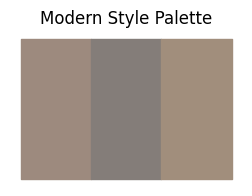

In [ ]:
import matplotlib.pyplot as plt

style_palette = {'modern': [(157, 138, 126), (132, 125, 121), (161, 142, 124)], 'industrial': [(102, 87, 73), (205, 205, 205), (114, 107, 103)], 'minimalist': [(172, 164, 151), (150, 126, 100), (78, 67, 52)], 'scandinavian': [(139, 112, 88), (151, 137, 126), (222, 216, 206)], 'boho': [(199, 195, 188), (185, 182, 174), (207, 201, 196)]}
def visualize_style_palette_input(style_palette):
    style = input("Enter a style (e.g., modern): ").lower()
    if style in style_palette:
        print(f"Recommended palette for '{style}':")
        plot_style_palette(style_palette[style], style)
    else:
        print("❌ Style not found.")
visualize_style_palette_input(style_palette)

In [ ]:

def create_recommendations_dict_from_filenames(df, style_color_mapping):
    recommendations = {}
    for _, row in df.iterrows():
        filename = os.path.basename(row["image_path"])
        style = row["style"]
        if style in style_color_mapping:
            dominant_color = row["dominant_color"]
            recommendations[filename] = {
                "style": style,
                "recommended_colors": style_color_mapping[style],
                "actual_color": dominant_color
            }
    return recommendations

recommendations_dict = create_recommendations_dict_from_filenames(features_df, style_color_mapping)


In [ ]:
def create_dataset(df, recommendations):
    data = []
    for _, row in df.iterrows():
        filename = os.path.basename(row["image_path"])
        if filename in recommendations:
            dominant_color = row["dominant_color"]
            style = row["style"]
            data.append({
                "r": dominant_color[0],
                "g": dominant_color[1],
                "b": dominant_color[2],
                "style": style
            })
    return pd.DataFrame(data)

ml_df = create_dataset(features_df, recommendations_dict)


(180, 177, 170)


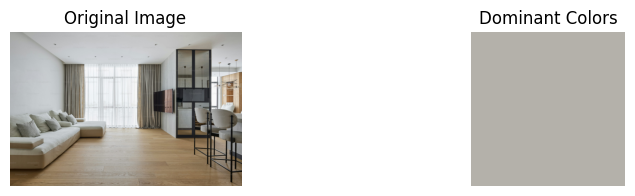

In [ ]:
from PIL import Image
img = Image.open("/content/room2.jpg")
dominant_color_and_palette = extract_dominant_and_palette('/content/room2.jpg')
dominant_color = dominant_color_and_palette[0]
print(dominant_color)

plt.figure(figsize=(10, 2))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title("Original Image")

plt.subplot(1, 2, 2)
color_array = np.array([[np.array(dominant_color) / 255]])
plt.imshow(color_array)
plt.axis('off')
plt.title("Dominant Colors")
plt.show()


In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def extract_color_palette(image_path, num_colors=10):
    # Load image and convert to RGB
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.reshape((-1, 3))

    # Apply KMeans
    kmeans = KMeans(n_clusters=num_colors)
    kmeans.fit(image)

    colors = kmeans.cluster_centers_.astype(int)
    counts = np.bincount(kmeans.labels_)

    # Sort by frequency
    sorted_idx = np.argsort(counts)[::-1]
    colors = colors[sorted_idx]

    # Plotting
    plt.figure(figsize=(10, 2))
    for i, color in enumerate(colors):
        plt.fill_between([i, i+1], 0, 1, color=color/255)
    plt.axis('off')
    plt.title('Color Palette')
    plt.show()

    return colors


Saving room1.jpg to room1 (2).jpg


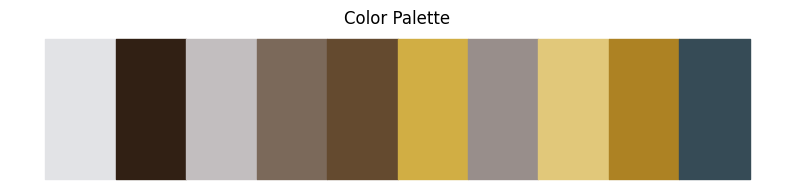

array([[226, 227, 230],
       [ 49,  32,  20],
       [194, 190, 191],
       [123, 105,  90],
       [100,  74,  47],
       [209, 174,  68],
       [152, 142, 139],
       [225, 200, 122],
       [173, 130,  35],
       [ 54,  75,  86]])

In [ ]:
def upload_and_extract_palette(num_colors=10):
    from google.colab import files
    uploaded_image = files.upload()
    if uploaded_image:
        image_filename = list(uploaded_image.keys())[0]
        colors = extract_color_palette(image_filename, num_colors)
        return colors
    else:
        print("No image file was uploaded.")
        return None
upload_and_extract_palette()

In [ ]:
# Encode style labels
le = LabelEncoder()
ml_df["style_encoded"] = le.fit_transform(ml_df["style"])
# ml_df["room_type_encoded"] = LabelEncoder().fit_transform(features_df["room_type"])


In [ ]:
X = ml_df[["r", "g", "b"]]
y = ml_df["style_encoded"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(),
    "SVM": SVC(kernel='rbf'),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

best_score = 0
best_model = None

for name, clf in models.items():
    scores = cross_val_score(clf, X_scaled, y, cv=5)
    print(f"{name} Cross-validation accuracy: {scores.mean():.4f}")
    if scores.mean() > best_score:
        best_score = scores.mean()
        best_model = clf


RandomForest Cross-validation accuracy: 0.3523
GradientBoosting Cross-validation accuracy: 0.3375
SVM Cross-validation accuracy: 0.3411
KNN Cross-validation accuracy: 0.3271


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid.fit(X_scaled, y)

print("Best Params:", grid.best_params_)
print("Best Score:", grid.best_score_)


Best Params: {'max_depth': 15, 'n_estimators': 200}
Best Score: 0.3691831834989398


In [ ]:
best_model.fit(X_scaled, y)


RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

In [ ]:
# Save Model and Encoders
joblib.dump(best_model, "tuned_rf_color_model.pkl")
joblib.dump(le, "label_encoder_enhanced.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [ ]:
print(f"✅ Best cross-validation accuracy: {best_score:.4f}")
print("✅ Best model training complete and saved.")


✅ Best cross-validation accuracy: 0.3523
✅ Best model training complete and saved.
